In this first work we simply explore the historic end-of-day stock data of four assets. We consider their change over time and model some Simple Moving Averages and Exponentially Weighted Moving Averages.
Finally we consider their log returns, testing them for normality and showing their cumulative returns. 

In [1]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import os
import scipy.stats as scs
import statsmodels.api as sm

os.chdir('data')

For simplicity we start with local data of the assets and consider only their close prices.
We first make a quick check of the data once imported and plot it to get a visual idea.

,AAPL,IBM,MSFT,NKE
date,,,,
2014-02-21,68.9821,152.3849,33.7870,36.0905
2014-02-24,69.2841,152.9351,33.5290,36.7323
2014-02-25,68.5631,152.7517,33.3956,36.8597
2014-02-26,67.9446,153.4436,33.3333,37.0060
2014-02-27,69.2999,154.4523,33.6803,36.9302


,AAPL,IBM,MSFT,NKE
min,67.94,104.41,33.33,33.53
mean,128.63,140.75,62.48,55.82
max,230.28,166.96,114.62,85.40
std,38.22,12.80,23.72,12.12


<AxesSubplot: xlabel='date'>

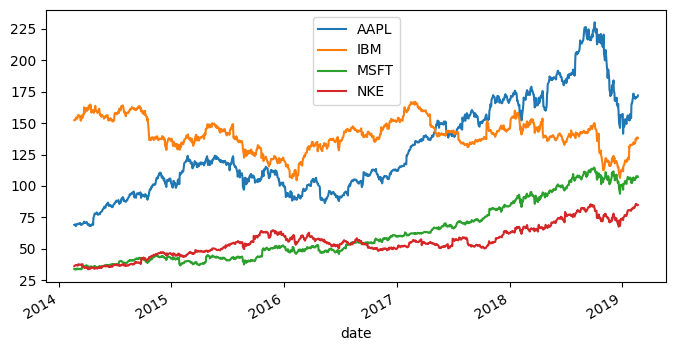

In [2]:
# get EOD data
eod = pd.DataFrame()

for name in ['AAPL','IBM','MSFT','NKE']:
    raw = pd.read_csv(name+'.csv', index_col=0, parse_dates=True)
    raw = raw[['close']]
    raw.rename({'close': name}, axis=1, inplace=True)
    eod = pd.concat([eod, raw], axis=1)

display(eod.head())
display(eod.aggregate([min, np.mean, max, np.std]).round(2))
eod.plot(figsize=(8,4))

Next we consider only the AAPL stock since 2018-06 and model a Simple Moving Average, ie. simply a rolling average over the past prices in a given window, in this case 42 closes.
More interestingly we plot an Exponentially Weighted Moving Average, as the name suggests it gives stronger weights to more recent data in an exponential way determined by the half-life.
Finally we also plot a moving average of the standard deviation.

,AAPL,mean,std,EWMA
date,,,,
2019-02-13,170.18,158.545198,8.444437,170.283721
2019-02-14,170.80,158.559010,8.464449,170.670930
2019-02-15,170.42,158.693457,8.609170,170.482733
2019-02-19,170.93,158.876557,8.788138,170.818183
2019-02-20,172.03,159.035350,8.966599,171.727046


<AxesSubplot: title={'center': 'AAPL std'}, xlabel='date'>

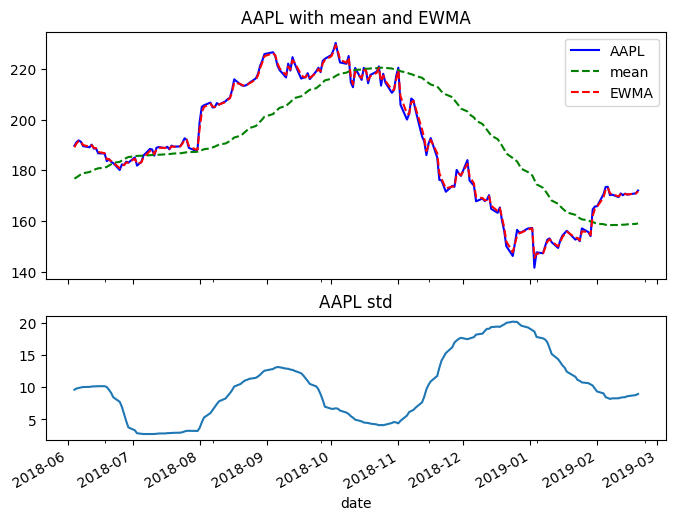

In [3]:
# get rolling statistics of mean, std and EWM
aapl = pd.DataFrame(eod['AAPL'])
window = 42
aapl['mean'] = aapl['AAPL'].rolling(window=window).mean()
aapl['std'] = aapl['AAPL'].rolling(window=window).std()
aapl['EWMA'] = aapl['AAPL'].ewm(halflife=0.5, min_periods=window).mean()
display(aapl.tail())

year_aapl = aapl[aapl.index > '2018-06-01']

fig, ax = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[2,1]}, sharex=True)
fig.set_size_inches(8,6)

year_aapl[['AAPL','mean','EWMA']].plot(ax=ax[0], 
                            style=['b','g--','r--'], title='AAPL with mean and EWMA')
year_aapl['std'].plot(ax=ax[1], title='AAPL std')

Now we consider the returns of these stocks, and specifically the log returns as is common due to their advantageous properties.
We compute the weekly log returns as the log of the weekly price divided by the previous week's price, and plot their cumulative run.

Text(0.5, 1.0, 'Cumulative weekly log returns')

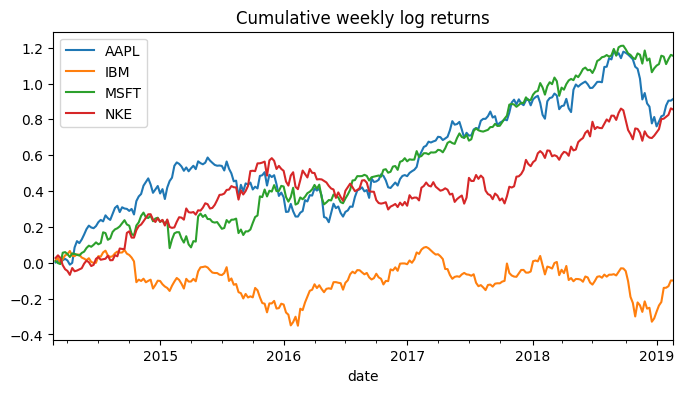

In [4]:
# get weekly cumulative log returns and plot
weekly_avg = eod.resample('1w', label='right').last()
weekly_log_returns = np.log(weekly_avg / weekly_avg.shift(1))

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

weekly_log_returns.cumsum().plot(ax=ax)
ax.set_title('Cumulative weekly log returns')

Now we look at the distribution of these weekly log return by plotting them as histograms.

C:\Users\jerem\AppData\Local\Temp\ipykernel_32376\4101613428.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  weekly_log_returns.hist(ax=ax, bins=40, figsize=(8,6), sharex=True, sharey=True)


array([[<AxesSubplot: title={'center': 'AAPL'}>,
        <AxesSubplot: title={'center': 'IBM'}>],
       [<AxesSubplot: title={'center': 'MSFT'}>,
        <AxesSubplot: title={'center': 'NKE'}>]], dtype=object)

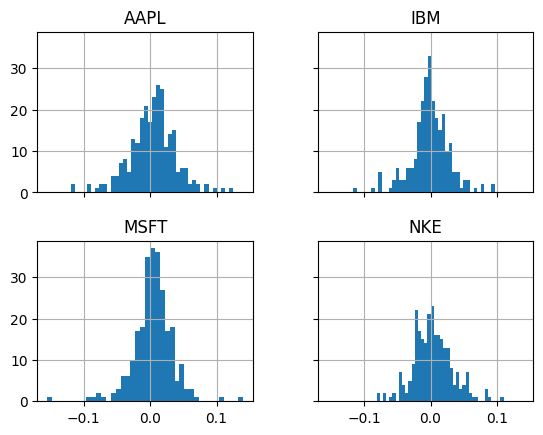

In [5]:
fig, ax = plt.subplots()
weekly_log_returns.hist(ax=ax, bins=40, figsize=(8,6), sharex=True, sharey=True)

Finally we test if the AAPL stock has normally distributed log returns.
This is done by taking as the null hypothesis that they are normally distributed and running a test, from which we consider the p-value.
We also plot a Quantil-Quantil plot between the log returns of AAPL stock and a normal distribution, from which we can judge visually if the data looks to fit a normal distribution.
Both of these tests strongly reject the idea that the stock is normally distributed.

p-value for testing normality as null: 0.0011.


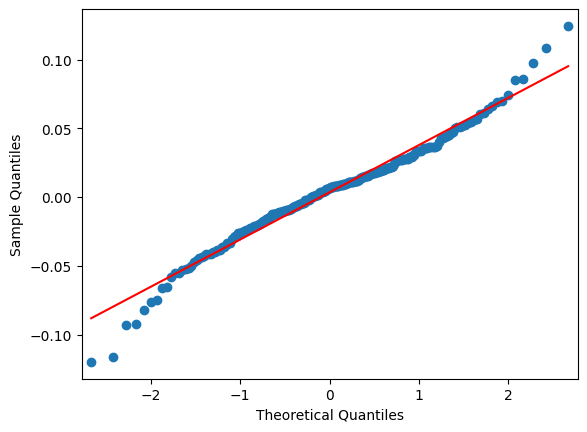

In [6]:
# testing normality for AAPL
aapl = weekly_log_returns.AAPL.dropna()
sm.qqplot(aapl, line="s")
print(f"p-value for testing normality as null: {round(scs.normaltest(aapl)[1], 4)}.")